In [1]:
import pandas as pd

from runner import *

plotpath = parent_directory + "\\plots\\"
plotting.set_dir(plotpath)

loading complete, calculating accuracy
getting human labeled boundaries
complete


In [18]:
cell_rna = RNA[RNA['process_index'] > 0].copy()

cell_rna['branch'] = cell_rna['process_index'].astype(str)
cell_rna['branch'] = cell_rna['branch'].str[0]
cell_rna['branch_name'] = cell_rna['cell_index'].astype(str) + "_" + cell_rna['branch']


blanks = cell_rna[cell_rna['barcode_id'] < 290]
minimum = np.array(blanks['barcode_id'].value_counts().reset_index(name='counts')['counts'])[int(np.floor(290*0.05))]
print(f'minimum {minimum}')

reals = cell_rna[cell_rna['barcode_id'] > 290]

real_counts = reals['barcode_id'].value_counts().rename_axis('barcode_id').reset_index(name='counts')
usable_ids = real_counts[real_counts['counts'] > minimum]

usable_rna = reals[reals['barcode_id'].isin(usable_ids['barcode_id'])]
usable_unlabeled_rna = RNA[RNA['barcode_id'].isin(usable_ids['barcode_id'])]

value_counted = usable_rna.groupby(['branch_name', 'barcode_id']).size().unstack(fill_value=0)
averaged = value_counted.divide(np.array(value_counted.sum(axis=1)), axis='rows')

minimum 11
barcode_id       291       292       294       296       297       298   \
branch_name                                                               
102_1        0.000000  0.014286  0.004762  0.000000  0.014286  0.000000   
107_1        0.000000  0.000000  0.007042  0.000000  0.021127  0.000000   
107_2        0.001404  0.004213  0.009831  0.000702  0.014747  0.002809   
107_3        0.001283  0.005988  0.005560  0.000000  0.013259  0.002566   
108_1        0.000000  0.005038  0.005038  0.000000  0.015113  0.000000   
...               ...       ...       ...       ...       ...       ...   
97_1         0.000000  0.000943  0.000943  0.000000  0.000943  0.000943   
98_1         0.002232  0.002232  0.006696  0.000000  0.006696  0.000000   
98_2         0.000000  0.002375  0.007126  0.000000  0.005938  0.000000   
99_1         0.002132  0.006397  0.002132  0.000000  0.010661  0.002132   
9_1          0.003249  0.003249  0.003249  0.000000  0.020143  0.008447   

barcode_id   

In [13]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=9, max_iter=1000)
embeddings = nmf.fit_transform(averaged)

C:\Users\Harrison\anaconda3\envs\Segmentation\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [14]:
from sklearn.manifold import TSNE
tsne = TSNE()
tsne_embeddings = tsne.fit_transform(embeddings)

C:\Users\Harrison\anaconda3\envs\Segmentation\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Harrison\anaconda3\envs\Segmentation\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


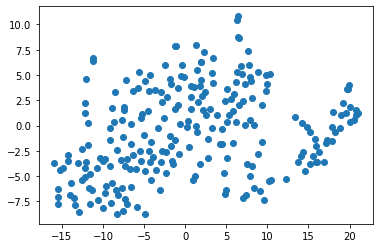

In [15]:
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])
plt.show()

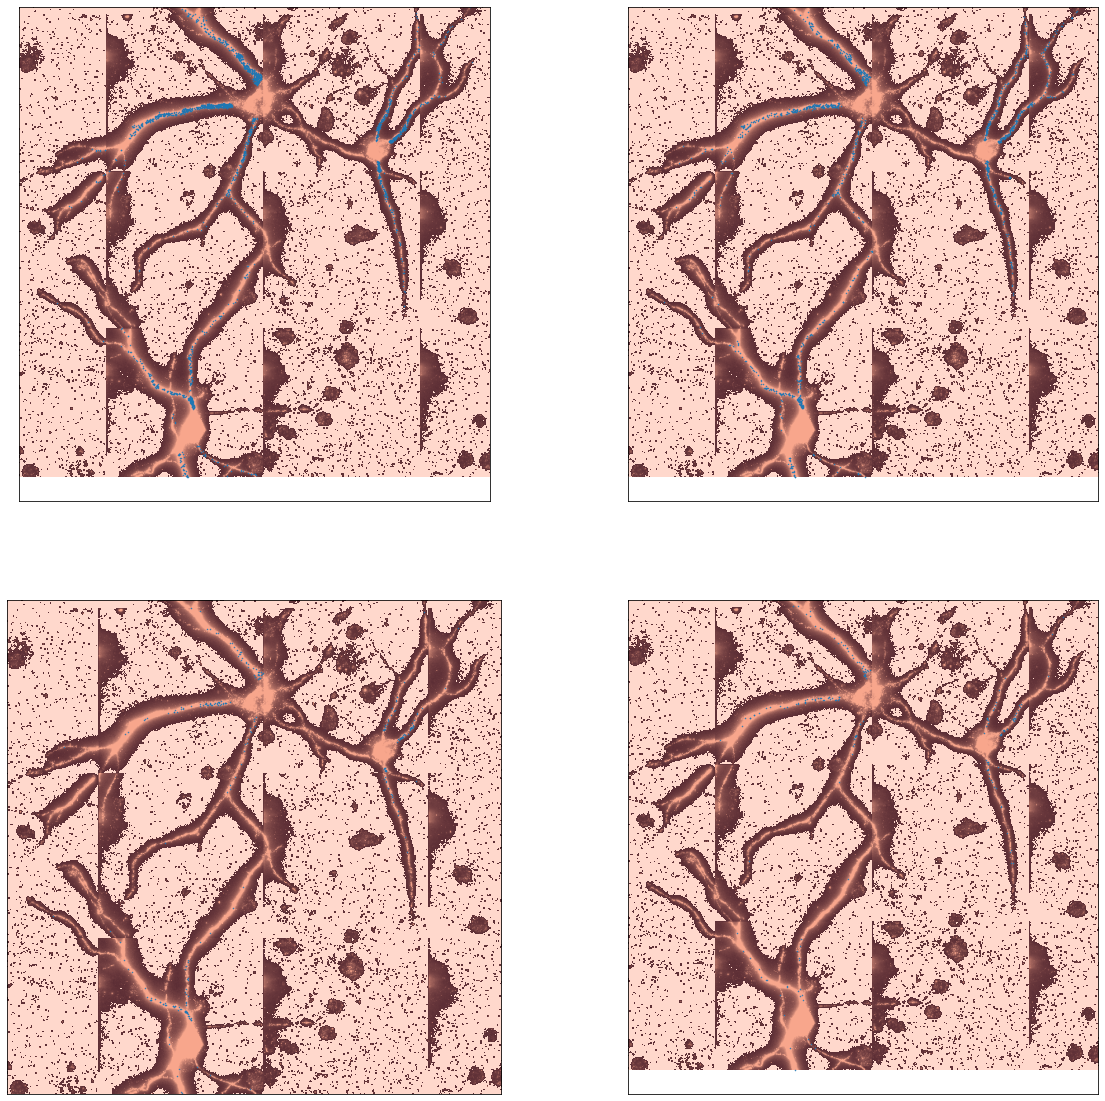

In [19]:
rec_rna = usable_rna[usable_rna['global_y'] < bbox_ymax]
rec_rna = rec_rna[rec_rna['global_y'] > bbox_ymin]
rec_rna = rec_rna[rec_rna['global_x'] < bbox_xmax]
rec_rna = rec_rna[rec_rna['global_x'] > bbox_xmin].copy()

rec_rna['global_y'] -= bbox_ymin
rec_rna['global_x'] -= bbox_xmin

# component = rec_rna[rec_rna['barcode_id'] == 1170]
max_component = pd.DataFrame({'barcode_id' : averaged.columns, 'max_component' : nmf.components_.argmax(axis=0)})
max_component.index = max_component['barcode_id']

components = np.array(max_component['max_component'].value_counts().index[:4])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

image = plotting.panel(preprocessed[:,:,1], bbox, 1)

for i, component in enumerate(components):
    ax = axes.flatten()[i]
    plotting.axplot(image, ax)
    this_rna = rec_rna[np.array(max_component['max_component'][rec_rna['barcode_id']]) == component]
    ax.scatter(this_rna['global_x'], this_rna['global_y'], s=0.25)

plt.show()

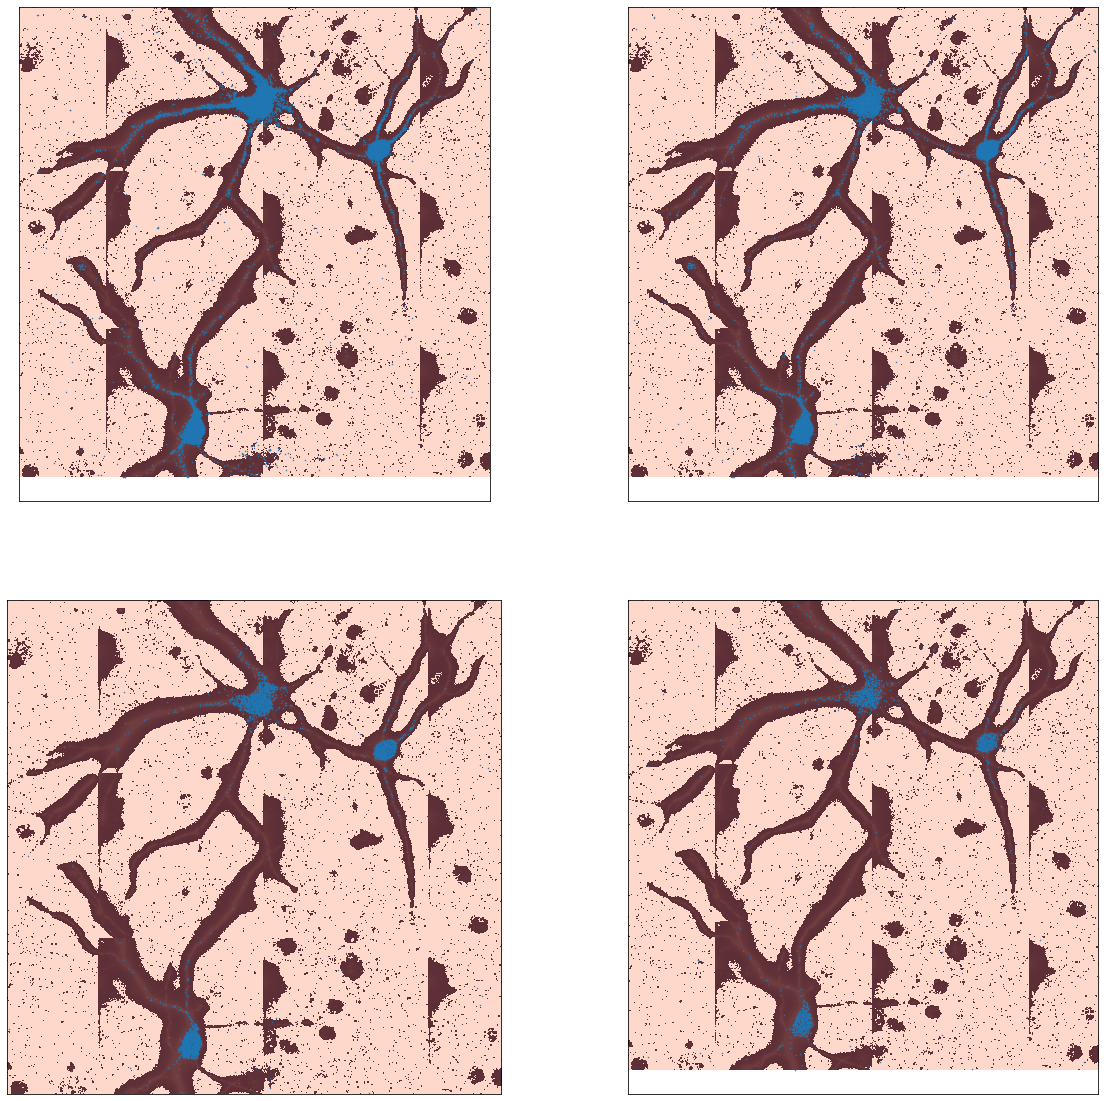

In [20]:
rec_rna = usable_unlabeled_rna[usable_unlabeled_rna['global_y'] < bbox_ymax]
rec_rna = rec_rna[rec_rna['global_y'] > bbox_ymin]
rec_rna = rec_rna[rec_rna['global_x'] < bbox_xmax]
rec_rna = rec_rna[rec_rna['global_x'] > bbox_xmin].copy()

rec_rna['global_y'] -= bbox_ymin
rec_rna['global_x'] -= bbox_xmin

components = np.array(max_component['max_component'].value_counts().index[:4])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

image = plotting.panel(preprocessed[:,:,1] * 0.001, bbox, 1)

for i, component in enumerate(components):
    ax = axes.flatten()[i]
    plotting.axplot(image, ax, vmax=1)
    this_rna = rec_rna[np.array(max_component['max_component'][rec_rna['barcode_id']]) == component]
    ax.scatter(this_rna['global_x'], this_rna['global_y'], s=0.25)

plt.show()

In [24]:
rna_p = RNA.copy()
rna_p['y'] = (np.floor(rna_p['global_y'])).astype(int)
rna_p['x'] = (np.floor(rna_p['global_x'])).astype(int)
rna_p['process'] = processImage[rna_p['y'], rna_p['x']]

In [71]:
rna_p_highv = rna_p[rna_p['barcode_id'].isin(usable_ids['barcode_id'])]
value_counted = rna_p_highv.groupby(['process', 'barcode_id']).size().unstack(fill_value=0)
averaged = value_counted.divide(np.array(value_counted.sum(axis=1)), axis='rows')

nmf = NMF(n_components=20, max_iter=1000)
embeddings = nmf.fit_transform(averaged)

tsne = TSNE(n_components=3, n_iter=10000)
tsne_embeddings = tsne.fit_transform(embeddings)

process_cols = pd.DataFrame({'process' : averaged.index,
                             'x_embed' : tsne_embeddings[:, 0],
                             'y_embed' : tsne_embeddings[:, 1],
                             'z_embed' : tsne_embeddings[:, 2]}
)
x = process_cols['x_embed']
process_cols['x_embed'] = (x - x.min())/(x.max() - x.min())
y = process_cols['y_embed']
process_cols['y_embed'] = (y - y.min())/(y.max() - y.min())
z = process_cols['z_embed']
process_cols['z_embed'] = (z - z.min())/(z.max() - z.min())
process_cols['c'] = list(map(tuple, np.vstack([process_cols['x_embed'], process_cols['y_embed'], process_cols['z_embed']]).T))

print(process_cols)


C:\Users\Harrison\anaconda3\envs\Segmentation\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\Harrison\anaconda3\envs\Segmentation\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Harrison\anaconda3\envs\Segmentation\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


      process   x_embed   y_embed   z_embed  \
0           0  0.607675  0.647258  0.367068   
1           1  0.411907  0.580480  0.696004   
2           2  0.456250  0.699702  0.704636   
3           3  0.425177  0.308904  0.343862   
4           4  0.600964  0.227399  0.648722   
...       ...       ...       ...       ...   
1404     1441  0.322282  0.478349  0.419612   
1405     1442  0.424236  0.617971  0.468282   
1406     1444  0.221281  0.377874  0.282288   
1407     1445  0.340726  0.415888  0.453187   
1408     1447  0.708934  0.726447  0.238603   

                                         c  
0        (0.60767484, 0.6472575, 0.367068)  
1       (0.411907, 0.58047956, 0.69600415)  
2     (0.45624977, 0.69970155, 0.70463634)  
3       (0.425177, 0.30890393, 0.34386176)  
4     (0.60096407, 0.22739919, 0.64872247)  
...                                    ...  
1404  (0.32228184, 0.47834855, 0.41961208)  
1405   (0.42423567, 0.61797136, 0.4682815)  
1406   (0.2212813, 0.37787354,

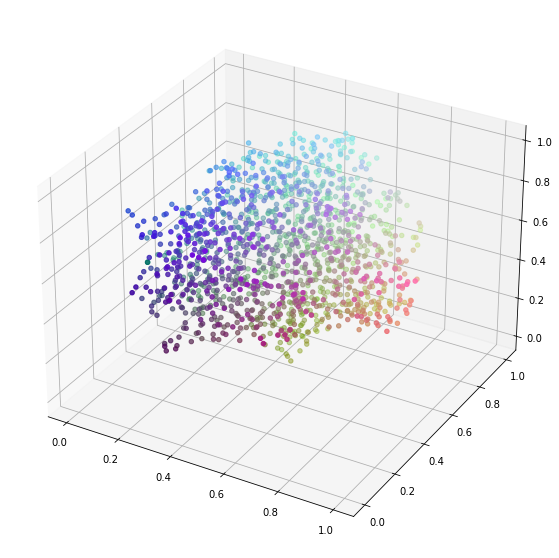

In [73]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(process_cols['x_embed'], process_cols['y_embed'], process_cols['z_embed'], c = process_cols['c'])
plt.show()

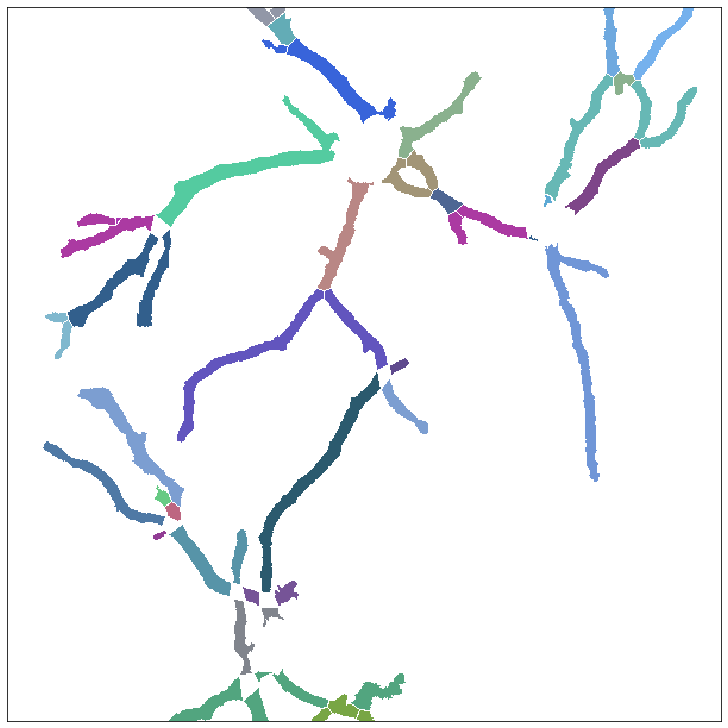

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [74]:
# def rgb2hex(r,g,b):
#     r *= 255
#     g *= 255
#     b *= 255
#     r = int(np.floor(r))
#     g = int(np.floor(g))
#     b = int(np.floor(b))
#     return "#{:02x}{:02x}{:02x}".format(r,g,b)
#
# cmap = {row['process'] : rgb2hex(*row['c']) for index, row in process_cols.iterrows()}
# cmap[0] = '#ffffff'
#
# plotting.colorplot(plotting.panel(processImage, bbox, 1), cmap, interpolation="None",
#                    name="embedding5")

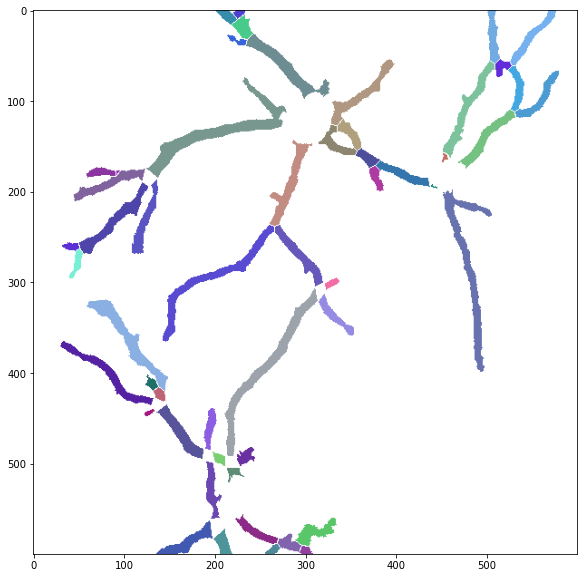

In [78]:
im = plotting.panel(processImage, bbox, 1)

embedded = np.ones((im.shape[0], im.shape[1], 3))
for iter, row in process_cols.iterrows():
    if iter == 0:
        continue
    embedded[im==row['process']] = row['c']

plt.figure(figsize=(10,10))
plt.imshow(embedded)
plt.savefig(plotpath + "embedimg6.png")